# ENSE 885AY Assignment 4: Scene Recognition with Bag-of-Words
For this assignment, you will need to report performance for three
combinations of features / classifiers. It is suggested you code them in
this order, as well:
1. Tiny image features and nearest neighbor classifier
2. Bag of sift features and nearest neighbor classifier
3. Bag of sift features and linear SVM classifier

The starter code is initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

## Experimental Design

## Setup

In [1]:
# Set up parameters, image paths and category list
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import os.path as osp
import pickle
from random import shuffle
import matplotlib.pyplot as plt
from utils import *
import student_code as sc


# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

# Number of training examples per category to use. Max is 100. For
# simplicity, we assume this is the number of test cases per category, as
# well.
num_train_per_cat = 100

# This function returns lists containing the file path for each train
# and test image, as well as lists with the label of each train and
# test image. By default all four of these lists will have 1500 elements
# where each element is a string.
data_path = osp.join('..', 'data')
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,
                                                                                 categories,
                                                                                 num_train_per_cat);

train_image_paths = np.array(train_image_paths)
test_image_paths = np.array(test_image_paths)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
N = test_image_paths.shape[0]

In [ ]:
## Build vocab files

In [2]:
print('Using the BAG-OF-SIFT representation for images')
vocab_filenames = ['vocab_size_10.pkl', 'vocab_size_20.pkl', 'vocab_size_50.pkl', 'vocab_size_100.pkl', \
                  'vocab_size_200.pkl', 'vocab_size_400.pkl', 'vocab_size_1000.pkl', 'vocab_size_10000.pkl']

vocab_sizes = [10, 20, 50, 100, 200, 400, 1000, 10000]

for k in range(len(vocab_filenames)):
    vocab_filename = vocab_filenames[k]
    if not osp.isfile(vocab_filename):
        # Construct the vocabulary
        print('No existing visual word vocabulary found. Computing one from training images')
        vocab_size = vocab_sizes[k]  # Larger values will work better (to a point) but be slower to compute
        vocab = sc.build_vocabulary(train_image_paths, vocab_size)
        with open(vocab_filename, 'wb') as f:
            pickle.dump(vocab, f)
            print('{:s} saved'.format(vocab_filename))

Using the BAG-OF-SIFT representation for images


## Cross validation

In [55]:
# Cross validation
# Define constant and varying parameters
exp_num = 10
cv_size = 150

# Initial matrices
CV_acc_knn_tiny = np.zeros([1,exp_num])
CV_acc_knn_sift = np.zeros([len(vocab_filenames),exp_num])
CV_acc_svm_sift = np.zeros([len(vocab_filenames),exp_num])

# Experiment 
# Experiment on random train & test datasets
for exp_idx in range(exp_num):
    # Generating random idx for trainCV & testCV dataset
    trainCV_idx = np.random.randint(N, size=cv_size)
    testCV_idx = np.random.randint(N, size=cv_size)
    
    # Obtain trainCV & testCV dataset
    trainCV_image_paths = train_image_paths[trainCV_idx]
    testCV_image_paths = test_image_paths[testCV_idx]
    
    trainCV_labels = train_labels[trainCV_idx]
    testCV_labels = test_labels[testCV_idx]

    # KNN  on tiny_images
    trainCV_image_feats = sc.get_tiny_images(trainCV_image_paths)
    testCV_image_feats = sc.get_tiny_images(testCV_image_paths)
    predicted_categories = \
    sc.nearest_neighbor_classify(trainCV_image_feats, trainCV_labels, testCV_image_feats)
    
    CV_acc_knn_tiny[0,exp_idx] = \
    sc.show_results_R1(trainCV_image_paths, testCV_image_paths, \
                       trainCV_labels, testCV_labels, categories, abbr_categories, predicted_categories)
    
    # KNN & SVM on bags_of_sifts
    for vocab_idx in range(len(vocab_filenames)):
        vocab_filename = vocab_filenames[vocab_idx]
        print('vocab_filename', vocab_filename)

        trainCV_image_feats = sc.get_bags_of_sifts(trainCV_image_paths, vocab_filename)
        testCV_image_feats = sc.get_bags_of_sifts(testCV_image_paths, vocab_filename)

        # KNN on bags_of_sifts
        predicted_categories = sc.nearest_neighbor_classify(trainCV_image_feats, trainCV_labels, testCV_image_feats)
        
        CV_acc_knn_sift[vocab_idx,exp_idx] = \
        sc.show_results_R1(trainCV_image_paths, testCV_image_paths, \
                           trainCV_labels, testCV_labels, categories, abbr_categories, predicted_categories)

        # SVM on bags_of_sifts
        predicted_categories = sc.svm_classify(trainCV_image_feats, trainCV_labels, testCV_image_feats, 3)
        CV_acc_svm_sift[vocab_idx,exp_idx] = \
        sc.show_results_R1(trainCV_image_paths, testCV_image_paths, \
                       trainCV_labels, testCV_labels, categories, abbr_categories, predicted_categories)

# Average accuracy
CV_acc_knn_tiny_mean = np.mean(CV_acc_knn_tiny)
CV_acc_knn_sift_mean = np.mean(CV_acc_knn_sift, axis=1)
CV_acc_svm_sift_mean = np.mean(CV_acc_svm_sift, axis=1)

# Standard deviation of accuracy
CV_acc_knn_tiny_std = np.std(CV_acc_knn_tiny)
CV_acc_knn_sift_std = np.std(CV_acc_knn_sift, axis=1)
CV_acc_svm_sift_std = np.std(CV_acc_svm_sift, axis=1)


## Cross validation Results

In [6]:
# Print Cross validation results
print('************** Cross validation results: **************\n')
print('******* KNN  on tiny_images: *******\n')
print('Average accuracy: \n', CV_acc_knn_tiny_mean, '\n\nStandard deviation of accuracy :\n', CV_acc_knn_tiny_std)

print(' \n \n******* KNN on bags_of_sifts: *******\n')
print( 'Average accuracy: \n', CV_acc_knn_sift_mean, '\n\nStandard deviation of accuracy :\n', CV_acc_knn_sift_std)

print(' \n \n******* SVM on bags_of_sifts: *******\n' , )
print('Average accuracy: \n', CV_acc_svm_sift_mean, '\n\nStandard deviation of accuracy :\n', CV_acc_svm_sift_std)

************** Cross validation results: **************

******* KNN  on tiny_images: *******

Average accuracy: 
 0.13199999999999998 

Standard deviation of accuracy :
 0.010770329614269013
 
 
******* KNN on bags_of_sifts: *******

Average accuracy: 
 [0.3   0.309 0.329 0.323 0.338 0.355 0.333 0.325] 

Standard deviation of accuracy :
 [0.0509902  0.04437342 0.04968903 0.03226453 0.05230679 0.03930649
 0.03348134 0.03383785]
 
 
******* SVM on bags_of_sifts: *******

Average accuracy: 
 [0.304 0.366 0.411 0.443 0.46  0.473 0.476 0.455] 

Standard deviation of accuracy :
 [0.03039737 0.01428286 0.037      0.04980964 0.04516636 0.05001
 0.04943683 0.06726812]


<IPython.core.display.Javascript object>


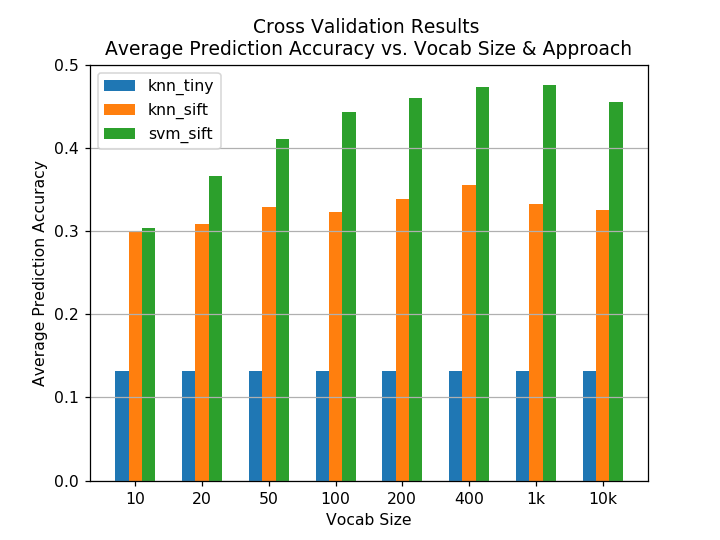

In [4]:
# Plot cross validation results
vocab_sizes_str = [10, 20, 50, 100, 200, 400, '1k', '10k']
x = 2*np.arange(len(vocab_sizes_str))
wid = 0.4


plt.figure()
k = 0; plt.bar(x-wid, CV_acc_knn_tiny_mean, width=wid, align='center', label='knn_tiny')
k = k+1; plt.bar(x, CV_acc_knn_sift_mean, width=wid, align='center', label='knn_sift')
k = k+1; plt.bar(x+wid, CV_acc_svm_sift_mean, width=wid, align='center', label='svm_sift')

plt.grid(b=None, which='major', axis='y')
plt.title("Cross Validation Results \nAverage Prediction Accuracy vs. Vocab Size & Approach")
plt.xlabel("Vocab Size")
plt.ylabel("Average Prediction Accuracy")
plt.xticks(x, vocab_sizes_str)#, rotation=20)
plt.legend()
plt.savefig("../results/CV_mean.png", bbox_inches = "tight", dpi=300)
plt.show()

<IPython.core.display.Javascript object>


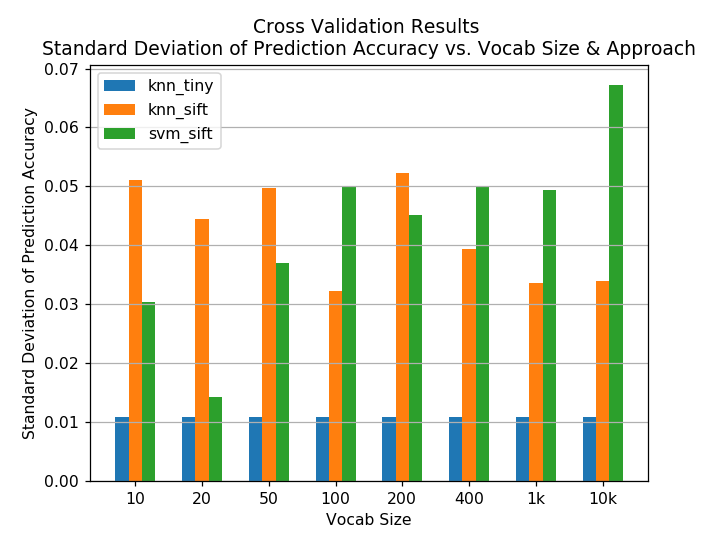

In [5]:
# Plot cross validation results
vocab_sizes_str = [10, 20, 50, 100, 200, 400, '1k', '10k']
x = 2*np.arange(len(vocab_sizes_str))
wid = 0.4


plt.figure()
k = 0; plt.bar(x-wid, CV_acc_knn_tiny_std, width=wid, align='center', label='knn_tiny')
k = k+1; plt.bar(x, CV_acc_knn_sift_std, width=wid, align='center', label='knn_sift')
k = k+1; plt.bar(x+wid, CV_acc_svm_sift_std, width=wid, align='center', label='svm_sift')

plt.grid(b=None, which='major', axis='y')
plt.title("Cross Validation Results \nStandard Deviation of Prediction Accuracy vs. Vocab Size & Approach")
plt.xlabel("Vocab Size")
plt.ylabel("Standard Deviation of Prediction Accuracy")
plt.xticks(x, vocab_sizes_str)#, rotation=20)
plt.legend()
plt.savefig("../results/CV_std.png", bbox_inches = "tight", dpi=300)
plt.show()

## Validation

In [58]:
# Validation

# Train dataset
# Train dataset: 1050 images from original train dataset (70 images per class)

# Validation dataset
# Validation dataset: 450 images from original train dataset (30 images per class)

# Generating random idx for validation dataset

N_val = 450
N_train = N - N_val
total_img_per_cat = int(N/len(categories))
trainV_img_per_cat = int(N_train/len(categories))

trainV_idx = []
val_idx = []
for cat_i in range(len(categories)):
    cat_idx = np.arange(cat_i*total_img_per_cat, (cat_i+1)*total_img_per_cat)
    trainV_idx.append(cat_idx[:trainV_img_per_cat])
    val_idx.append(cat_idx[trainV_img_per_cat:])
    # val_idx.append(np.random.randint(cat_i*total_img_per_cat, (cat_i+1)*total_img_per_cat, size=val_img_per_cat))

trainV_idx = np.array(trainV_idx).flatten()
val_idx = np.array(val_idx).flatten()

# val_image_paths & labels
trainV_image_paths = train_image_paths[trainV_idx]
trainV_labels = train_labels[trainV_idx]

# val_image_paths & labels
val_image_paths = test_image_paths[val_idx]
val_labels = test_labels[val_idx]

# Initial matrices
svm_lambda = [0.1, 0.5, 1, 3, 5, 7]
val_knn_tiny = 0
val_knn_sift = np.zeros(len(vocab_filenames))
val_svm_sift = np.zeros([len(svm_lambda), len(vocab_filenames)])


# KNN on tiny_images
trainV_image_feats = sc.get_tiny_images(trainV_image_paths)
val_image_feats = sc.get_tiny_images(val_image_paths)
predicted_categories = \
sc.nearest_neighbor_classify(trainV_image_feats, trainV_labels, val_image_feats)
val_knn_tiny = sc.show_results_R1(trainV_image_paths, val_image_paths, trainV_labels, val_labels, categories, abbr_categories,
         predicted_categories)

# KNN & SVM on bags_of_sifts
for vocab_idx in range(len(vocab_filenames)):
    vocab_filename = vocab_filenames[vocab_idx]
    print('vocab_filename: ', vocab_filename)

    # KNN on bags_of_sifts
    trainV_image_feats = sc.get_bags_of_sifts(trainV_image_paths, vocab_filename)
    val_image_feats = sc.get_bags_of_sifts(val_image_paths, vocab_filename)
    predicted_categories = sc.nearest_neighbor_classify(trainV_image_feats, trainV_labels, val_image_feats)
    val_knn_sift[vocab_idx] = sc.show_results_R1(trainV_image_paths, val_image_paths, \
                       trainV_labels, val_labels, categories, abbr_categories, predicted_categories)
    # SVM on bags_of_sifts
    for lam_idx in range(len(svm_lambda)):
        predicted_categories = sc.svm_classify(trainV_image_feats, trainV_labels, val_image_feats, svm_lambda[lam_idx])
        val_svm_sift[lam_idx, vocab_idx] = sc.show_results_R1(trainV_image_paths, val_image_paths, \
                       trainV_labels, val_labels, categories, abbr_categories, predicted_categories)


## Validation Results

In [9]:
# Print Validation Results
print('************** Validation Results **************\n')
print('******* KNN  on tiny_images: *******\n')
print('Accuracy: \n', val_knn_tiny)

print(' \n \n******* KNN on bags_of_sifts: *******\n')
print( 'Accuracy: \n', val_knn_sift)

print(' \n \n******* SVM on bags_of_sifts: *******\n' , )
print('Accuracy: \n', val_svm_sift)

************** Validation Results **************

******* KNN  on tiny_images: *******

Accuracy: 
 0.21
 
 
******* KNN on bags_of_sifts: *******

Accuracy: 
 [0.4  0.47 0.48 0.49 0.52 0.51 0.5  0.43]
 
 
******* SVM on bags_of_sifts: *******

Accuracy: 
 [[0.25 0.41 0.47 0.53 0.6  0.6  0.63 0.61]
 [0.29 0.42 0.5  0.56 0.6  0.61 0.65 0.62]
 [0.33 0.45 0.51 0.58 0.61 0.65 0.67 0.66]
 [0.4  0.48 0.54 0.6  0.66 0.67 0.7  0.67]
 [0.31 0.47 0.55 0.62 0.64 0.65 0.68 0.68]
 [0.38 0.49 0.56 0.63 0.64 0.64 0.68 0.68]]


<IPython.core.display.Javascript object>


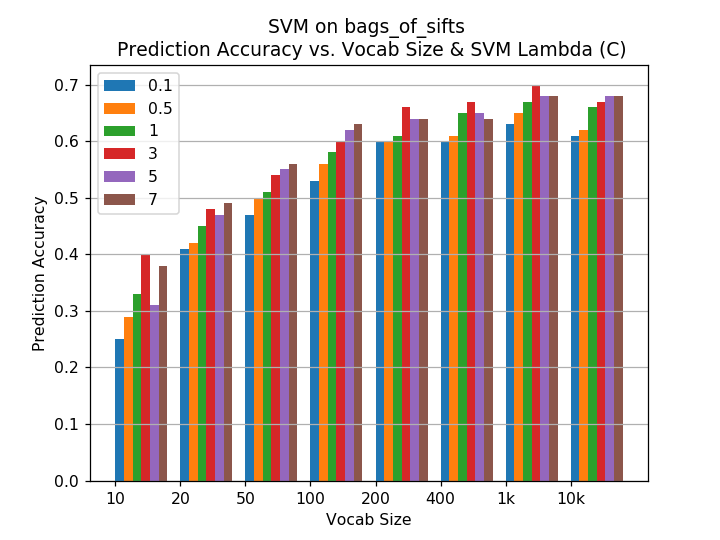

In [7]:
# Plot for SVM on bags_of_sifts
C = [0.1, 0.5, 1, 3, 5, 7]
vocab_sizes_str = [10, 20, 50, 100, 200, 400, '1k', '10k']
x = 3*np.arange(len(vocab_sizes_str))-3*wid
wid = 0.4


plt.figure()
for k in range(len(C)):
    plt.bar(x+k*wid, val_svm_sift[k,:], width=wid, align='edge', label=C[k])
    
plt.grid(b=None, which='major', axis='y')
plt.title("SVM on bags_of_sifts \n Prediction Accuracy vs. Vocab Size & SVM Lambda (C)")
plt.xlabel("Vocab Size")
plt.ylabel("Prediction Accuracy")
plt.xticks(x, vocab_sizes_str)#, rotation=20)
plt.legend()
plt.savefig("../results/val_svm_sift.png", bbox_inches = "tight", dpi=300)
plt.show()

<IPython.core.display.Javascript object>


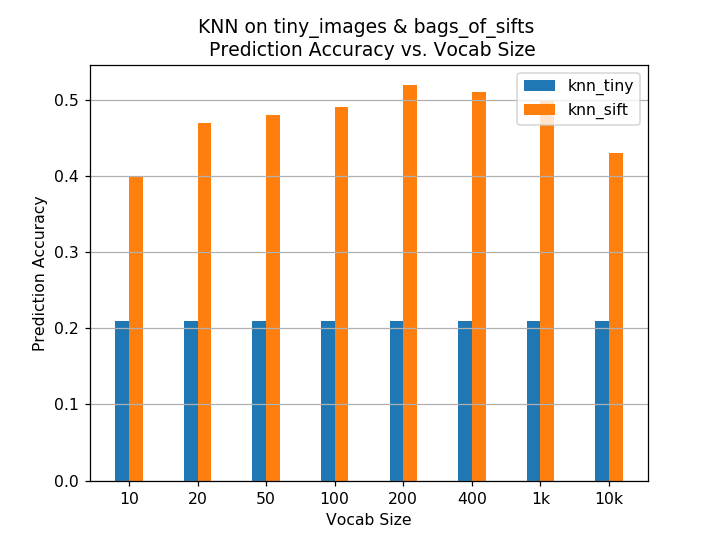

In [8]:
# Plot for KNN on tiny_images & bags_of_sifts
vocab_sizes_str = [10, 20, 50, 100, 200, 400, '1k', '10k']
x = 2*np.arange(len(vocab_sizes_str))
wid = 0.4


plt.figure()
k = 0; plt.bar(x-wid, val_knn_tiny, width=wid, align='edge', label='knn_tiny')
k = k+1; plt.bar(x, val_knn_sift, width=wid, align='edge', label='knn_sift')

plt.grid(b=None, which='major', axis='y')
plt.title("KNN on tiny_images & bags_of_sifts \n Prediction Accuracy vs. Vocab Size")
plt.xlabel("Vocab Size")
plt.ylabel("Prediction Accuracy")
plt.xticks(x, vocab_sizes_str)#, rotation=20)
plt.legend()
plt.savefig("../results/val_knn_tiny_sift.png", bbox_inches = "tight", dpi=300)
plt.show()